In [1]:
import numpy as np
from mpl_toolkits import mplot3d
from rom_am import POD, DMD, ROM
import matplotlib.pyplot as plt
import scipy.interpolate as si

## Loading Data from simulation results

In [2]:
case = 0 # 0 if mass = 1000 case; 1 if mass = 350 
if case == 0:
    folder_name = "../DATA/Fsi/Fsi_Results/"
else:
    folder_name = "../DATA/Fsi/Fsi_Results_mass_350/"

pist_pressure = np.load(folder_name+"pist_pressure.npy")
nnt = pist_pressure.shape[0]
fl_pressure = np.load(folder_name+"fl_pressure.npy")
fl_rho_e = np.load(folder_name+"fl_rho_e.npy")
fl_rho_v = np.load(folder_name+"fl_rho_v.npy")
fl_velocity_end = np.load(folder_name+"fl_velocity_end.npy")
fl_rho = np.load(folder_name+"fl_rho.npy")
moving_mesh = np.load(folder_name+"fl_moving_mesh.npy")
delta_t = np.load(folder_name+"delta_t.npy")
fl_energy = fl_rho_e/fl_rho
fl_velocity = fl_rho_v/fl_rho
s_accel = np.load(folder_name+"sol_accel.npy")
Ec = np.load(folder_name+"Ec.npy")
Em = np.load(folder_name+"Em.npy")
Ep = np.load(folder_name+"Ep.npy")
Imp_fl = np.load(folder_name+"Imp_fl.npy")

t_data = np.cumsum(delta_t)
nx = fl_pressure.shape[0]
nt = fl_pressure.shape[1]

## Problem parameters 
L = 1 # Piston (gas chamber) length
L0 = 1 # Initial Piston (gas chamber) length
mass = 1000 # Mass of the spring
rigid = 1e7  # stiffeness of the spring
Ls0 = 1.2 # Unstretched spring length
Lse = Ls0 - 1e5 / rigid # Length under pressure at rest

## ----------------------------------------------------------------------------------------------------------------------

## POD Reconstruction

In [3]:
# Training data
X = fl_pressure

In [4]:
pod = POD()
roml = ROM(pod)
roml.decompose(X)

In [5]:
rank = 4
rec_X = roml.reconstruct(rank)

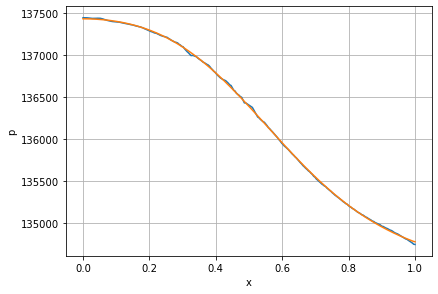

In [6]:
domain = np.linspace(0, L, nx)

plt.plot(domain, X[: , -1]);
plt.plot(domain, rec_X[: ,  -1]);
plt.grid();
plt.tight_layout();

plt.xlabel("x");
plt.ylabel("p");

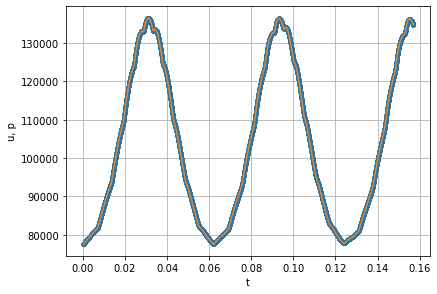

In [7]:
plt.plot(t_data, X[-1, :], '.');
plt.plot(t_data, rec_X[-1, :]);
plt.grid();
plt.tight_layout();

plt.xlabel("t");
plt.ylabel("u, p");

## ----------------------------------------------------------------------------------------------------------------------

## DMD Reduction

**The High Fidelity (HF) solution**

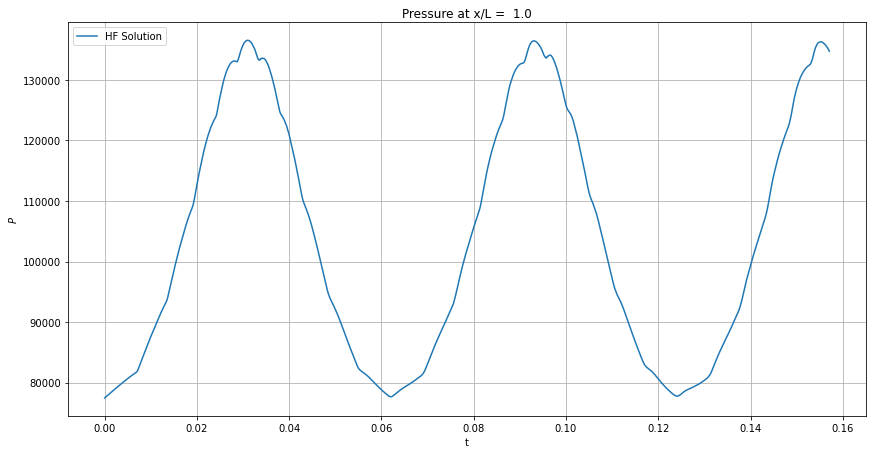

In [8]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(t_data, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();
plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

The HF solution captures 2.5 periods of the system, we will train the ROM on 1.75 periods and 200 points and the rest will be used for testing

**Interpolate to fixed time intervals**

In [9]:
# Choose number of equally spaced timesteps 
n_T = 2.5 # ~ Number of modes in data
n_snap = 280 # Number of snapshots in the train data
frac = 1.75 # ~ Number of time periods in the train data
ntt = int(n_snap /(frac/n_T)) # Number of snapshots in the test+train data
dt = (t_data[-1] - t_data[0]) / (ntt - 1) # New (fixed) time step

# Interpolating original data to the new timesteps
t = np.linspace(t_data[0], t_data[-1], ntt)
pressure = si.griddata(t_data, fl_pressure.T, t, method='nearest').T
velocity = si.griddata(t_data, fl_velocity.T, t, method='nearest').T
mesh = si.griddata(t_data, moving_mesh.T, t, method='nearest').T
sol_accel = si.griddata(t_data, s_accel.T, t, method='nearest').T

**Separating training and testing data**

In [10]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/n_T

## Training data ============================
train_pressure = pressure[:, :int(Coeff*ntt)]
train_velocity = velocity[:, :int(Coeff*ntt)]
train_mesh = mesh[:, :int(Coeff*ntt)]
train_sol_accel = sol_accel[:int(Coeff*ntt)][np.newaxis, :]
train_t = t[:int(Coeff*ntt)]

## Testing data ============================
test_pressure = pressure[:, int(Coeff*ntt)::]
test_velocity = velocity[:, int(Coeff*ntt)::]
test_mesh = mesh[:, int(Coeff*ntt)::]
test_sol_accel = sol_accel[int(Coeff*ntt)::][np.newaxis, :]
test_t = t[int(Coeff*ntt)::]

train_data_1 = np.concatenate((train_pressure, train_velocity, train_mesh))
train_data_2 = np.concatenate((train_pressure, train_velocity,))
train_data_3 = np.concatenate((train_pressure, train_velocity, train_mesh, train_sol_accel))

# Training data (Disregarding solid acceleration)
X = train_data_1[:, :-1]
Y = train_data_1[:, 1::]

# Training data (Disregarding mesh displacement)
X2 = train_data_2[:, :-1]
Y2 = train_data_2[:, 1::]

# Training data (Disregarding mesh displacement)
X3 = train_data_3[:, :-1]
Y3 = train_data_3[:, 1::]

**DMD reduction**

In [11]:
rank = 0
dmd = DMD()
drom = ROM(dmd)
drom.decompose(X,  Y = Y, dt = dt, rank =rank, normalize=True)

In [12]:
rank = 0
dmd2 = DMD()
drom2 = ROM(dmd2)
drom2.decompose(X2,  Y = Y2, dt = dt, rank =rank, normalize=True)

In [13]:
rank = 0
dmd3 = DMD()
drom3 = ROM(dmd3)
drom3.decompose(X3,  Y = Y3, dt = dt, rank =rank, normalize=True)

**DMD modes**

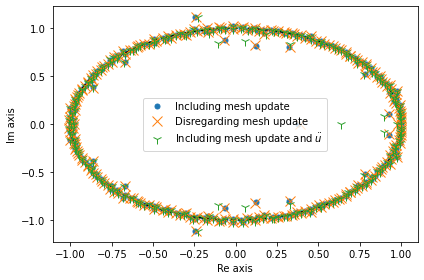

In [14]:
plt.plot(np.real(drom.model.lambd), np.imag(drom.model.lambd), '.', markersize = 10, label = "Including mesh update");
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.plot(np.real(drom2.model.lambd), np.imag(drom2.model.lambd), 'x', markersize = 10, label = "Disregarding mesh update");
plt.plot(np.real(drom3.model.lambd), np.imag(drom3.model.lambd), '1', markersize = 10, label = r"Including mesh update and $\ddot{u}$");
plt.legend();
plt.tight_layout();

## Reconstructing X

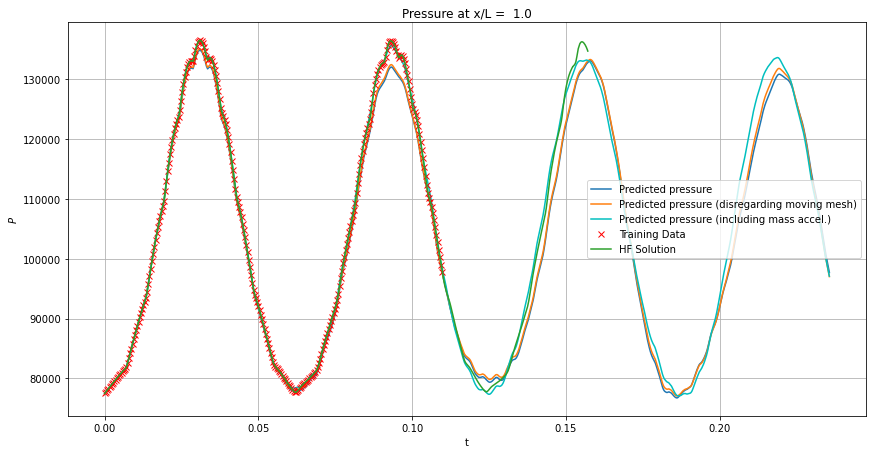

In [15]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1
satbilize_ = True
prediction_t = np.concatenate((t, np.linspace(t[-1] + dt, 1.5 * t[-1], int(ntt))))

fig = plt.figure(figsize = (12, 6))
predicted_X = np.real(drom.predict(prediction_t, t1 = t[0], stabilize=satbilize_))
predicted_X2 = np.real(drom2.predict(prediction_t, t1 = t[0], stabilize=satbilize_))
predicted_X3 = np.real(drom3.predict(prediction_t, t1 = t[0], stabilize=satbilize_))

predicted_mesh = predicted_X[2 * nx::, :]
predicted_pressure = predicted_X[:nx, :]
predicted_pressure_nomesh = predicted_X2[:nx, :]
predicted_pressure_accel = predicted_X3[:nx, :]
predicted_mesh_accel = predicted_X3[2 * nx: 3*nx, :]

plt.plot(prediction_t, predicted_pressure[-x_n, :], '-', label = "Predicted pressure")
plt.plot(prediction_t, predicted_pressure_nomesh[-x_n, :], '-', label = "Predicted pressure (disregarding moving mesh)")
plt.plot(prediction_t, predicted_pressure_accel[-x_n, :], '-c', label = "Predicted pressure (including mass accel.)")
plt.plot(train_t, train_pressure[-x_n, :], 'xr', label = "Training Data");

plt.plot(t_data, fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));

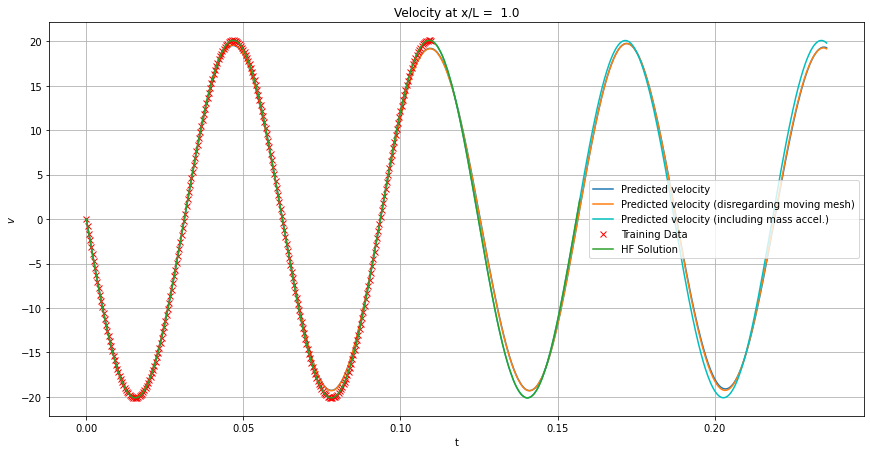

In [16]:
fig = plt.figure(figsize = (12, 6))

predicted_velocity = predicted_X[nx:2*nx, :]
predicted_velocity_nomesh = predicted_X2[nx:2*nx, :]
predicted_velocity_accel = predicted_X3[nx:2*nx, :]

plt.plot(prediction_t, predicted_velocity[-x_n, :], '-', label = "Predicted velocity")
plt.plot(prediction_t, predicted_velocity_nomesh[-x_n, :], '-', label = "Predicted velocity (disregarding moving mesh)")
plt.plot(prediction_t, predicted_velocity_accel[-x_n, :], '-c', label = "Predicted velocity (including mass accel.)")
plt.plot(train_t, train_velocity[-x_n, :], 'xr', label = "Training Data");

plt.plot(t_data, fl_velocity[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$v$");
plt.title("Velocity at x/L =  " + str(L * (nx - x_n + 1)/nx));

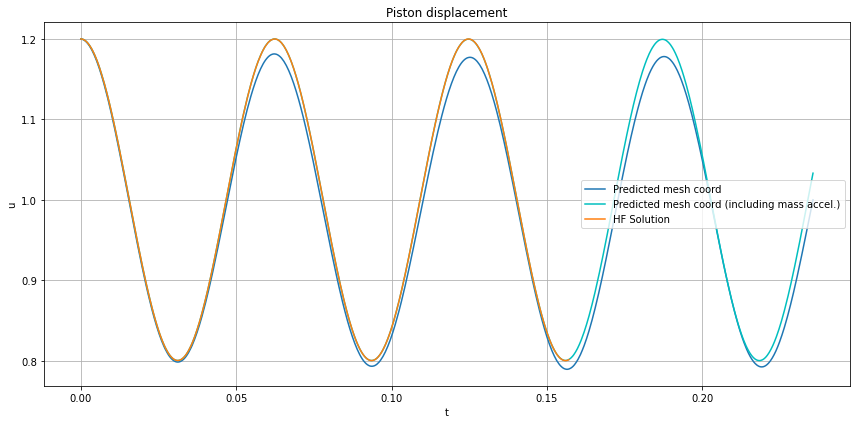

In [17]:
fig = plt.figure(figsize = (12, 6))

plt.plot(prediction_t, predicted_mesh[-1, :], '-', label = "Predicted mesh coord");
plt.plot(prediction_t, predicted_mesh_accel[-1, :], '-c', label = "Predicted mesh coord (including mass accel.)");
plt.plot(t_data, moving_mesh[-1, :], '-', label = "HF Solution");
plt.legend();
plt.grid();
plt.title("Piston displacement");
plt.xlabel("t");
plt.ylabel("u");
plt.tight_layout();

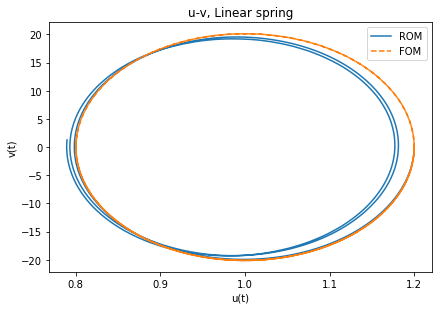

In [18]:
figure = plt.figure()
plt.plot(predicted_mesh[-1, :t.shape[0]], predicted_velocity[-1, :t.shape[0]], label = 'ROM');
plt.plot(moving_mesh[-1, :], fl_velocity_end[-1, :], '--', label = 'FOM');
plt.tight_layout();
plt.legend();
plt.xlabel("u(t)")
plt.ylabel("v(t)")
plt.title(r"u-v, Linear spring");

**Energy Conservation**

In [19]:
mass = 1000
rigid = 1e7
def fl_nrj(pres, delta_t, u_dot_t):
    return np.cumsum(- pres * delta_t * u_dot_t)

def mech_nrj(u_dot_t, u_t):
    return .5 * (mass * u_dot_t**2 + rigid * (-u_t - Ls0 + Lse)**2)

predicted_dt = np.concatenate((np.array([t_data[0]]), np.diff(prediction_t)))

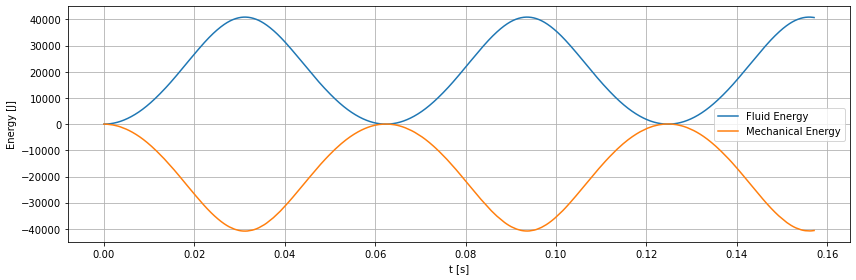

In [20]:
figure = plt.figure(figsize = (12, 4))
plt.plot(t_data, Imp_fl, label = 'Fluid Energy');
plt.plot(t_data, Em - Em[0], label = 'Mechanical Energy');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

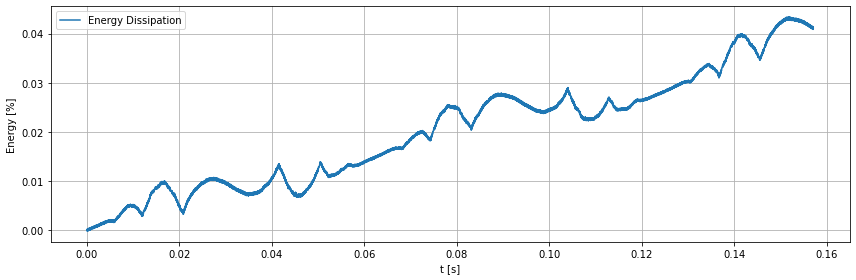

In [21]:
figure = plt.figure(figsize = (12, 4))
plt.plot(t_data, 100 * (Imp_fl + Em - Em[0])/Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

In [22]:
dmd_imp_fl = fl_nrj(predicted_pressure_accel[-1, :], predicted_dt, predicted_velocity_accel[-1, :])
dmd_Em = mech_nrj(predicted_velocity_accel[-1, :], predicted_mesh_accel[-1, :] - L0)

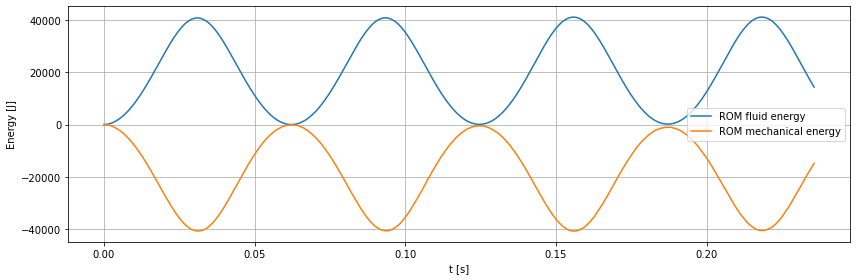

In [23]:
figure = plt.figure(figsize = (12, 4))
plt.plot(prediction_t, dmd_imp_fl, label = 'ROM fluid energy')
plt.plot(prediction_t, dmd_Em - dmd_Em[0], label = 'ROM mechanical energy')
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

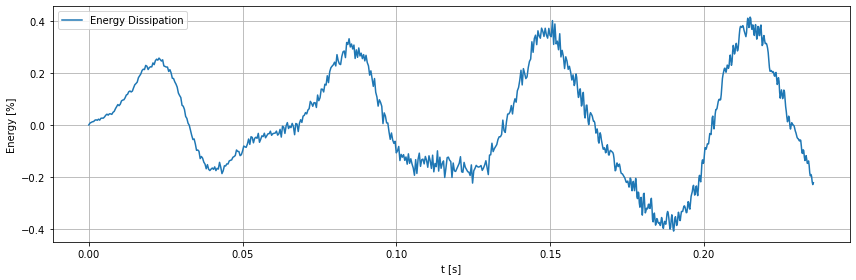

In [24]:
figure = plt.figure(figsize = (12, 4))
plt.plot(prediction_t, 100 * (dmd_imp_fl + dmd_Em - dmd_Em[0])/dmd_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

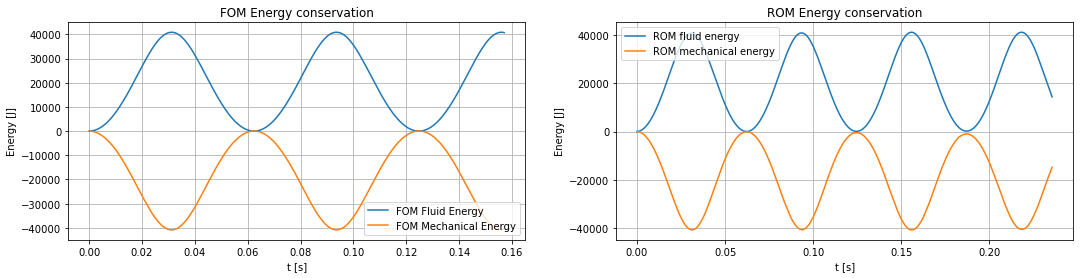

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

ax[0].plot(t_data, Imp_fl, label = 'FOM Fluid Energy');
ax[0].plot(t_data, Em - Em[0], label = 'FOM Mechanical Energy');
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Energy [J]");
ax[0].set_title("FOM Energy conservation");
ax[0].legend();

ax[1].plot(prediction_t, dmd_imp_fl, label = 'ROM fluid energy');
ax[1].plot(prediction_t, dmd_Em - dmd_Em[0], label = 'ROM mechanical energy');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Energy [J]");
ax[1].set_title("ROM Energy conservation");
ax[1].legend();

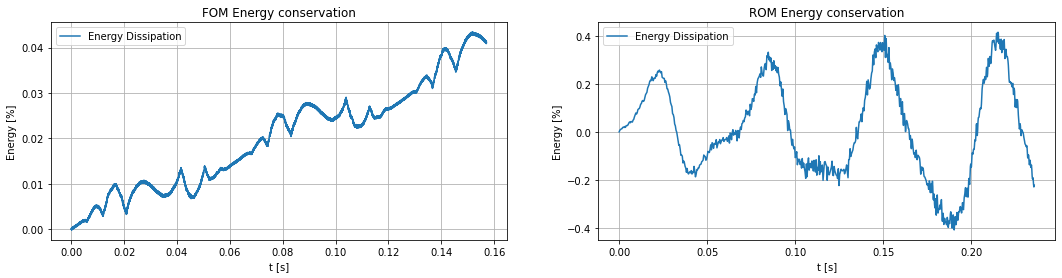

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (18, 4))

ax[0].plot(t_data, 100 * (Imp_fl + Em - Em[0])/Em, label = 'Energy Dissipation');
ax[0].grid();
ax[0].set_xlabel("t [s]");
ax[0].set_ylabel("Energy [%]");
ax[0].legend();
ax[0].set_title("FOM Energy conservation");

ax[1].set_title("ROM Energy conservation");
ax[1].plot(prediction_t, 100 * (dmd_imp_fl + dmd_Em - dmd_Em[0])/dmd_Em, label = 'Energy Dissipation');
ax[1].grid();
ax[1].set_xlabel("t [s]");
ax[1].set_ylabel("Energy [%]");
ax[1].legend();

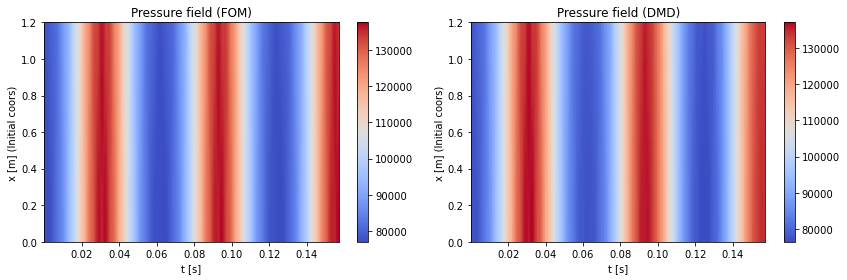

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

x0 = t_data.copy()
y0 = moving_mesh[:,0]
z0 = fl_pressure.copy()
z_min0, z_max0 = z0.min(), z0.max()

c0 = ax[0].pcolormesh(x0, y0, z0, cmap ='coolwarm', vmin = z_min0, vmax = z_max0, shading='auto')
plt.colorbar(c0, ax=ax[0])
ax[0].set_title('Pressure field (FOM)')
ax[0].set_ylabel("x [m] (Initial coors)")
ax[0].set_xlabel("t [s]")


x1 = prediction_t[:t.shape[0]+1]
y1 = moving_mesh[:,0]
z1 = predicted_pressure_accel[:, :t.shape[0]+1].copy()
z_min1, z_max1 = z1.min(), z1.max()

c1 = ax[1].pcolormesh(x1, y1, z1, cmap ='coolwarm', vmin = z_min1, vmax = z_max1, shading = 'auto')
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Pressure field (DMD)')
ax[1].set_ylabel("x [m] (Initial coors)")
ax[1].set_xlabel("t [s]")

plt.tight_layout()
plt.show()

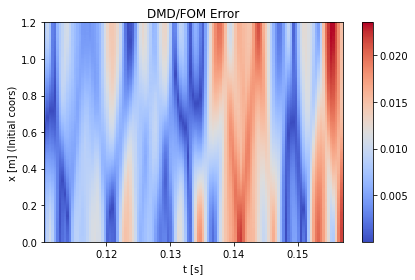

In [28]:
fig = plt.figure()

id0 = int(ntt*Coeff)
id1 = t.shape[0]
reference = test_pressure
predicted = predicted_pressure_accel[:, id0:id1]

x0 = t[id0::]
y0 = moving_mesh[:,0]
z0 = np.sqrt(((predicted - reference)**2))/np.sqrt(((reference)**2))
z_min0, z_max0 = z0.min(), z0.max()

c0 = plt.pcolormesh(x0, y0, z0, cmap ='coolwarm', vmin = z_min0, vmax = z_max0, shading = 'auto')
plt.colorbar(c0, ax=ax[0])
plt.title('DMD/FOM Error')
plt.ylabel("x [m] (Initial coors)")
plt.xlabel("t [s]")
plt.colorbar()

plt.tight_layout()
plt.show()

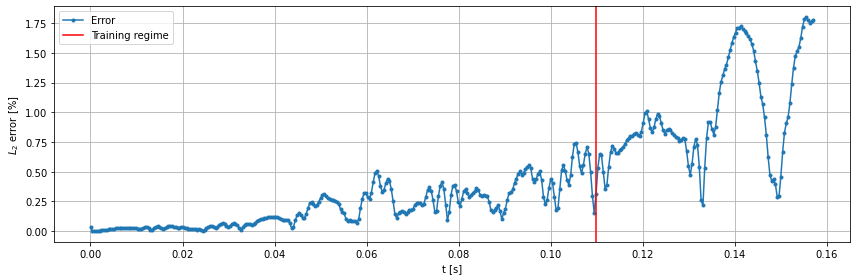

In [29]:
figure = plt.figure(figsize = (12, 4))

reference = np.vstack((pressure, velocity, mesh, sol_accel))
pred_t = t.copy()
prediction = np.real(drom3.predict(pred_t, t1 = t[0], stabilize=satbilize_))
errors = np.linalg.norm(prediction-reference, axis =0)/np.linalg.norm(reference, axis =0)

plt.plot(t, 100 * errors, '.-', label = 'Error');
plt.axvline(x = train_t[-1], color = 'red', label = 'Training regime');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("$L_2$ error [%]");
plt.legend();
plt.tight_layout();

## Display

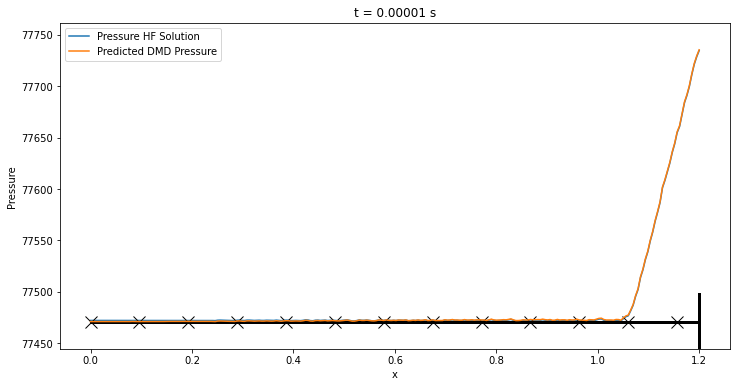

In [30]:
import matplotlib.animation as animation
fig, ax = plt.subplots(figsize = (12, 6))

x = mesh[:, 0]
line, = ax.plot(x, pressure[:, 0], label = "Pressure HF Solution");
thresh = pressure[:, 0].min()*.9
line2, = ax.plot(x, thresh * np.ones(x.shape[0]), 'k', linewidth = 3,);
line3, = ax.plot(mesh[-1, 0] * np.ones(50), np.linspace(thresh * .96, thresh * 1.04, 50), 'k', linewidth = 3,);
line4, = ax.plot(x[::20], thresh * np.ones(x[::20].shape[0]), 'kx', linewidth = 3, markersize = 12);
line5, = ax.plot(x, pressure[:, 0], label = "Predicted DMD Pressure");
plt.xlabel("x")
plt.ylabel("Pressure")

def animate(i):
    
    plt.title(f"t = {t[i]:.5f} s");
    
    length = max(pressure[:, i+1].max(), predicted_pressure_accel[:, i+1].max())  - min(pressure[:, i+1].min(), predicted_pressure_accel[:, i+1].min())
    thresh = min(pressure[:, i+1].min(), predicted_pressure_accel[:, i+1].min()) - .1 * length

    ax.set_ylim(top = max(pressure[:, i+1].max(), predicted_pressure_accel[:, i+1].max()) + .1 * length, bottom = thresh);

    line.set_xdata(mesh[:, i+1])  ;
    line.set_ydata(pressure[:, i+1]) ;
    
    line2.set_xdata(mesh[:, i+1])  ;
    line2.set_ydata(thresh + .1 * length) ;
    
    line3.set_xdata(mesh[-1, i+1]) ;
    line3.set_ydata(np.linspace(thresh, thresh + length *  .2, 50));
    
    line4.set_xdata(mesh[:, i+1][::20]) ; 
    line4.set_ydata(thresh + .1 * length);
    
    line5.set_xdata(predicted_mesh_accel[:, i+1])  ;
    line5.set_ydata(predicted_pressure_accel[:, i+1]);
    return line, line2, line3, line4, line5

plt.legend();
ani = animation.FuncAnimation(
    fig, animate, interval=110, blit=False, save_count=mesh.shape[1]-1);

# save the animation - Uncomment to save the animation video (expensive and probably requires ffmpeg)
#ani.save("Pressure_in_Fluid.mp4")

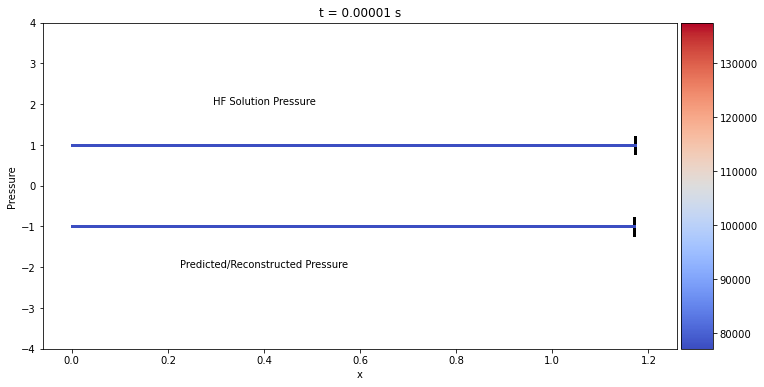

In [31]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

n_cut = 9

fig, ax = plt.subplots(figsize = (12, 6))

pres_max = np.abs(pressure).max()
pres_min = np.abs(pressure).min()

norm = plt.cm.colors.Normalize(vmin=pres_min, vmax=pres_max)
colors = plt.cm.coolwarm(norm(pressure[::n_cut, :]))
colors2 = plt.cm.coolwarm(norm(predicted_pressure_accel[::n_cut, :]))

x = mesh[:, 0][::n_cut]
x2 = predicted_mesh_accel[:, 0][::n_cut]

for j in range(len(x)-1):
    line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, 0, :],);
    line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, 0, :],);

line3, = ax.plot(mesh[-1, 0] * np.ones(2), np.linspace(.96, 1.04, 2), 'k', linewidth = 3,);
line4, = ax.plot(predicted_mesh_accel[-1, 0] * np.ones(2), np.linspace(-.96, -1.04, 2), 'k', linewidth = 3,);

plt.xlabel("x")
plt.ylabel("Pressure")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cmap = mpl.cm.coolwarm

ax.text(.4, 2, "HF Solution Pressure", ha = "center")
ax.text(.4, -2, "Predicted/Reconstructed Pressure", ha = "center")

def animate(i):
    x = mesh[:, i][::n_cut]
    x2 = predicted_mesh_accel[:, i][::n_cut]

    ax.set_title(f"t = {t[i]:.5f} s");
    ax.set_ylim(top = 4, bottom = -4);

    if i>0:
        ax.plot(mesh[:, i-1][::n_cut], np.ones(x.shape[0]),  'w', linewidth = 3,);
        ax.plot(predicted_mesh_accel[:, i-1][::n_cut], -np.ones(x.shape[0]),  'w', linewidth = 3,);

    for j in range(len(x)-1):
        line2, = ax.plot([x[j], x[j+1]], [1, 1], linewidth = 3, color = colors[j, i, :]);
        line5, = ax.plot([x2[j], x2[j+1]], [-1, -1], linewidth = 3, color = colors2[j, i, :]);

    line3.set_xdata(x[-1]) ;
    line3.set_ydata(np.linspace(.8, 1.2, 2));

    line4.set_xdata(x2[-1]) ;
    line4.set_ydata(np.linspace(-.8, -1.2, 2));

    return line2, line3, line4, line5

cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation="vertical")

ani = animation.FuncAnimation(
    fig, animate, interval=95, blit=True, save_count=mesh.shape[1]);

# save the animation - Uncomment to save the animation video (expensive and probably requires ffmpeg)
# ani.save("Pressure_in_Fluid_2.mp4")

**DMD modes (Regularization)**

When dealing with ill-conditioned input matrices regularization methods should be used to deal with the least square problem; we are using the well-known Tikhonov regularization in our case, i.e minimizing 
$$ \|\pmb A \pmb X - \pmb Y\|^2 + \lambda \|\pmb A\|^2 cond(\pmb X)$$
instead of 
$$ \|\pmb A \pmb X - \pmb Y\|^2$$

Here we use ```tikhonov = 1e-9``` instead of the default ```tikhonov = 0``` (no regularization)

PS : We first change the timestep for training snapshots to better highlight the ill-conditioning problem

In [32]:
# Choose number of equally spaced timesteps 
ntt = 510
dt = (t_data[-1] - t_data[0]) / (ntt - 1)

# Interpolating original data to the new timesteps
t = np.linspace(t_data[0], t_data[-1], ntt)
pressure = si.griddata(t_data, fl_pressure.T, t, method='nearest').T
velocity = si.griddata(t_data, fl_velocity.T, t, method='nearest').T
mesh = si.griddata(t_data, moving_mesh.T, t, method='nearest').T
sol_accel = si.griddata(t_data, s_accel.T, t, method='nearest').T
domain = np.linspace(0, L, nx)

Coeff = .8

# Training data (considering moving mesh AND mass acceleration)
XY_DATA_3 = np.concatenate((pressure[:, :int(ntt * Coeff)], velocity[:, :int(ntt * Coeff)], 
                          mesh[:, :int(ntt * Coeff)], sol_accel[:int(ntt * Coeff)][np.newaxis, :]))
X3 = XY_DATA_3[:, :-1]
Y3 = XY_DATA_3[:, 1::]

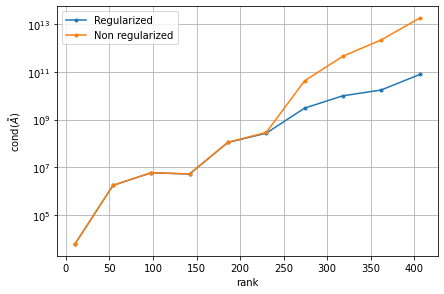

In [33]:
rank = np.linspace(10, X3.shape[1], 10).astype(int)
cond_ = np.zeros((len(rank), 2))

j=0
for i in rank:
    rank_ = i
    
    dmd3c = DMD()
    drom3c = ROM(dmd3c)
    drom3c.decompose(X3,  Y = Y3, dt = dt, rank = rank_, sorting = "abs", tikhonov=1e-9)
    
    dmd3 = DMD()
    drom3 = ROM(dmd3)
    drom3.decompose(X3,  Y = Y3, dt = dt, rank = rank_, sorting = "abs", tikhonov=0)
    
    cond_[j, 0] = np.linalg.cond(drom3c.model.A_tilde)
    cond_[j, 1] = np.linalg.cond(drom3.model.A_tilde)
    j+= 1
    
fig = plt.figure();
it = plt.semilogy(rank, cond_, '.-');
plt.grid()
plt.tight_layout();
plt.ylabel(r"cond($\tilde{A}$)", fontsize = 10);
plt.xlabel("rank");
plt.legend(it, ("Regularized", "Non regularized"));

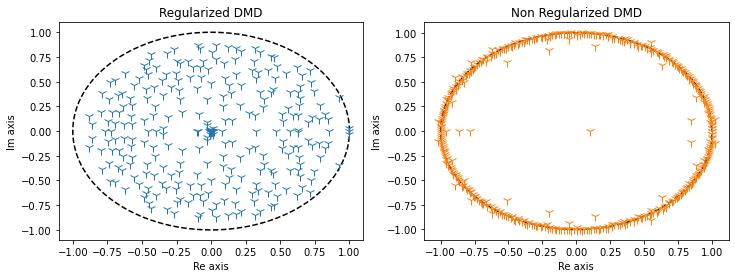

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].set_xlabel("Re axis");
ax[0].set_ylabel("Im axis");
ax[1].set_xlabel("Re axis");
ax[1].set_ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
ax[0].plot(np.cos(theta), np.sin(theta), "k--");
ax[1].plot(np.cos(theta), np.sin(theta), "k--");

ax[0].set_title("Regularized DMD");
ax[0].plot(np.real(drom3c.model.lambd), np.imag(drom3c.model.lambd), '1', markersize = 10);
ax[1].set_title("Non Regularized DMD");
ax[1].plot(np.real(drom3.model.lambd), np.imag(drom3.model.lambd), '1', color = u'#ff7f0e', markersize = 10);

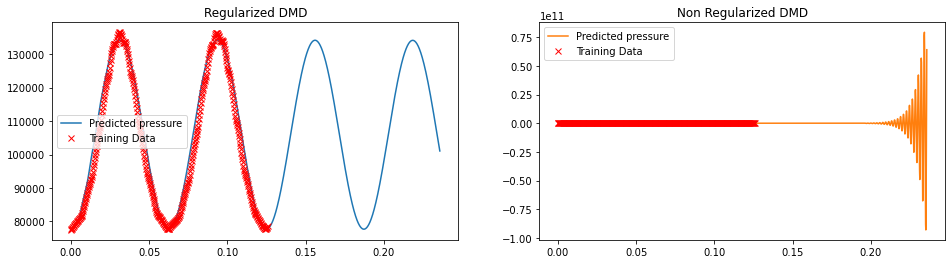

In [35]:
fig, ax = plt.subplots(1, 2, figsize = (16, 4))
prediction_t = np.concatenate((t, np.linspace(t[-1] + dt, 1.5 * t[-1], int(ntt))))
predicted_X3c = np.real(drom3c.predict(prediction_t, t1 = t[0]))
predicted_X3 = np.real(drom3.predict(prediction_t, t1 = t[0], stabilize=False))

pred_presc = predicted_X3c[:nx, :]
pred_pres = predicted_X3[:nx, :]

ax[0].plot(prediction_t, pred_presc[-1, :], '-', label = "Predicted pressure");
ax[0].plot(t[: int(ntt * Coeff)], pressure[-1, :int(ntt * Coeff)], 'xr', label = "Training Data");

ax[1].plot(prediction_t, pred_pres[-1, :], '-', color =  u'#ff7f0e', label = "Predicted pressure");
ax[1].plot(t[: int(ntt * Coeff)], pressure[-1, :int(ntt * Coeff)], 'xr', label = "Training Data");

ax[0].set_title("Regularized DMD");
ax[1].set_title("Non Regularized DMD");
ax[0].legend();
ax[1].legend();

--------------------------------------------------------------------------------------------------------------------------------------------

## Non linear spring

We use now a non linear model, parametrized by $k$ the spring stiffeness and $\mu$ for the non linear term:

$m \ddot u = K (L_s(t) - L_{s0}) + \mu (L_s(t) - L_{s0})^3 + A p(t)$

where $\mu = \frac{6 * K}{u_0}$

---------------------------------------------------------------------------------------------------------

**Load the data** -----------------------------------------------------------------------------------------------------------

In [36]:
case = 6 # 6 if mu_coeff = 6 case; 2 if mu_coeff = 2 
if case == 6:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results/"
    mu_coeff = 6.
else:
    folder_name = "../DATA/Fsi/nonlin_Fsi_Results_coeff_2/"
    mu_coeff = 2.

    
nln_pist_pressure = np.load(folder_name+"nln_pist_pressure.npy")
nln_nnt = nln_pist_pressure.shape[0]
nln_fl_pressure = np.load(folder_name+"nln_fl_pressure.npy")
nln_fl_rho_e = np.load(folder_name+"nln_fl_rho_e.npy")
nln_fl_rho_v = np.load(folder_name+"nln_fl_rho_v.npy")
nln_fl_velocity_end = np.load(folder_name+"nln_fl_velocity_end.npy")
nln_fl_rho = np.load(folder_name+"nln_fl_rho.npy")
nln_moving_mesh = np.load(folder_name+"nln_moving_mesh.npy")
nln_delta_t = np.load(folder_name+"nln_delta_t.npy")
nln_s_accel = np.load(folder_name+"nln_sol_accel.npy")
nln_fl_energy = np.load(folder_name+"nln_fl_energy.npy")
nln_fl_velocity = np.load(folder_name+"nln_fl_velocity.npy")
nln_fl_velocity_end = np.load(folder_name+"nln_fl_velocity_end.npy")
nln_Ec = np.load(folder_name+"nln_Ec.npy")
nln_Em = np.load(folder_name+"nln_Em.npy")
nln_Ep = np.load(folder_name+"nln_Ep.npy")
nln_Imp_fl = np.load(folder_name+"nln_Imp_fl.npy")

nln_t_data = np.cumsum(nln_delta_t)
nln_nt = nln_fl_pressure.shape[1]

--------------------------------------------------------------------------------------------------

In [37]:
nln_force = mass * nln_s_accel - nln_pist_pressure
force = mass * s_accel - pist_pressure

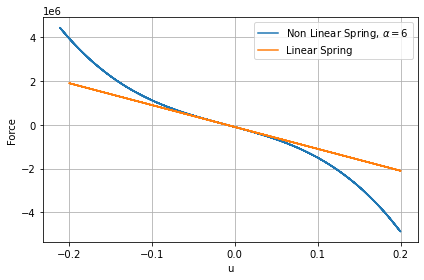

In [38]:
plt.plot(nln_moving_mesh[-1, :] - L0, nln_force, label=r"Non Linear Spring, $\alpha = 6$")
plt.plot(moving_mesh[-1, :] - L0, force, label="Linear Spring")
plt.xlabel("u");
plt.ylabel("Force");
plt.grid();
plt.legend();
plt.tight_layout();

In [39]:
# Choose number of equally spaced timesteps 
nln_T = 3.5 # ~ Number of modes in data
n_snap = 280 # Number of snapshots in the train data
frac = 1.75 # ~ Number of time periods in the train data
nln_ntt = int(n_snap /(frac/n_T)) # Number of snapshots in the test+train data
nln_dt = (nln_t_data[-1] - nln_t_data[0]) / (nln_ntt - 1) # New (fixed) time step

# Interpolating original data to the new timesteps
nln_t = np.linspace(nln_t_data[0], nln_t_data[-1], nln_ntt)
nln_pressure = si.griddata(nln_t_data, nln_fl_pressure.T, nln_t, method='nearest').T
nln_velocity = si.griddata(nln_t_data, nln_fl_velocity.T, nln_t, method='nearest').T
nln_mesh = si.griddata(nln_t_data, nln_moving_mesh.T, nln_t, method='nearest').T
nln_sol_accel = si.griddata(nln_t_data, nln_s_accel.T, nln_t, method='nearest').T

In [40]:
# Choose coefficient of time interval(of data) chosen for training
Coeff = frac/nln_T

# Training data (considering moving mesh)
train_nln_pressure = nln_pressure[:, :int(nln_ntt * Coeff)]
train_nln_velocity = nln_velocity[:, :int(nln_ntt * Coeff)]
train_nln_mesh = nln_mesh[:, :int(nln_ntt * Coeff)]
train_nln_sol_accel = nln_sol_accel[:int(nln_ntt * Coeff)][np.newaxis, :]
train_nln_t = nln_t[:int(nln_ntt * Coeff)]

test_nln_pressure = nln_pressure[:, int(nln_ntt * Coeff)::]
test_nln_velocity = nln_velocity[:, int(nln_ntt * Coeff)::]
test_nln_mesh = nln_mesh[:, int(nln_ntt * Coeff)::]
test_nln_sol_accel = nln_sol_accel[int(nln_ntt * Coeff)::][np.newaxis, :]
test_nln_t = nln_t[int(nln_ntt * Coeff)::]

train_nln_data = np.concatenate((train_nln_pressure, train_nln_velocity, train_nln_mesh, train_nln_sol_accel))

nln_X = train_nln_data[:, :-1]
nln_Y = train_nln_data[:, 1::]

rank = 0
nln_dmd = DMD()
nln_drom = ROM(nln_dmd)
nln_drom.decompose(nln_X,  Y = nln_Y, dt = nln_dt, rank = rank, normalize=True,)

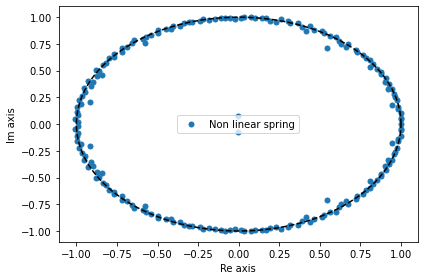

In [41]:
plt.plot(np.real(nln_drom.model.lambd), np.imag(nln_drom.model.lambd), '.', markersize = 10, label = "Non linear spring");
plt.xlabel("Re axis");
plt.ylabel("Im axis");
theta = np.linspace(0, 2*np.pi, 1024)
plt.plot(np.cos(theta), np.sin(theta), "k--");

plt.legend();
plt.tight_layout();

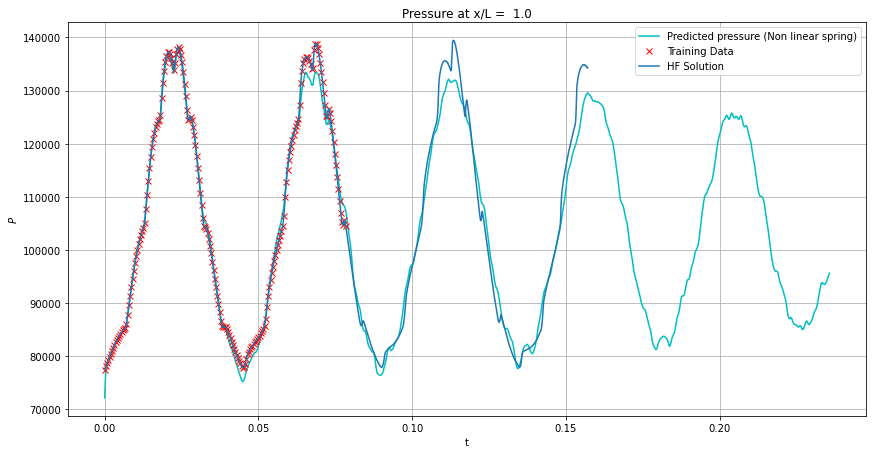

In [42]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))
nln_prediction_t = np.concatenate((nln_t, np.linspace(nln_t[-1] + nln_dt, 1.5 * nln_t[-1], int(nln_ntt))))
nln_predicted_X = np.real(nln_drom.predict(nln_prediction_t, t1 = nln_t[0], stabilize = True))

nln_predicted_pressure = nln_predicted_X[:nx, :]
nln_predicted_velocity = nln_predicted_X[nx:2*nx, :]
nln_predicted_disp = nln_predicted_X[2*nx:3*nx, :]

plt.plot(nln_prediction_t, nln_predicted_pressure[-x_n, :], '-c', label = "Predicted pressure (Non linear spring)")
plt.plot(train_nln_t, train_nln_pressure[-x_n, :], 'xr', label = "Training Data");

plt.plot(nln_t_data, nln_fl_pressure[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");
plt.title("Pressure at x/L =  " + str(L * (nx - x_n + 1)/nx));


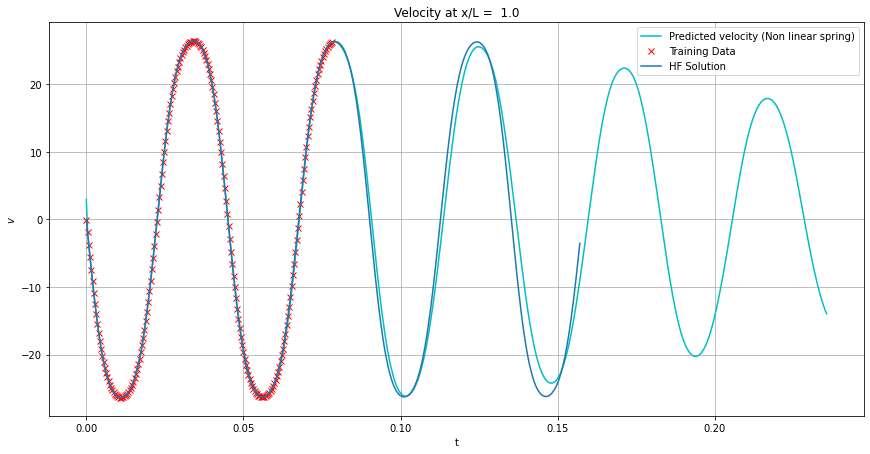

In [43]:
# Node number from Right to left (fluid domain) (Far left node having index 1) -----------
x_n = 1

fig = plt.figure(figsize = (12, 6))

plt.plot(nln_prediction_t, nln_predicted_velocity[-x_n, :], '-c', label = "Predicted velocity (Non linear spring)")
plt.plot(train_nln_t, train_nln_velocity[-x_n, :], 'xr', label = "Training Data");

plt.plot(nln_t_data, nln_fl_velocity[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$v$");
plt.title("Velocity at x/L =  " + str(L * (nx - x_n + 1)/nx));

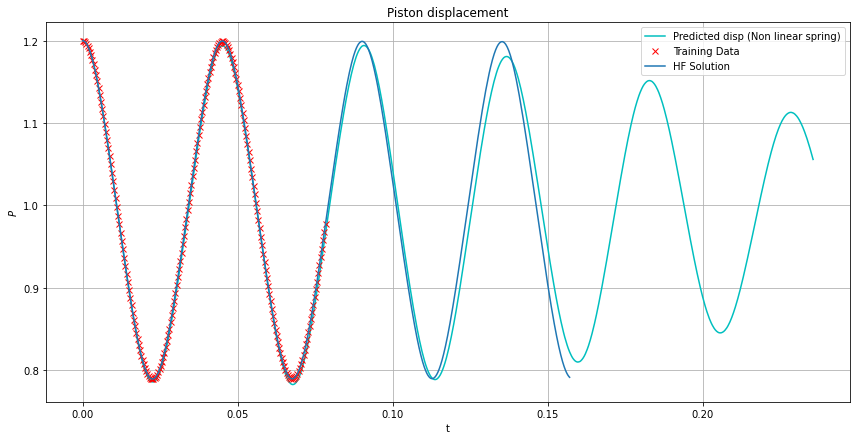

In [44]:
fig = plt.figure(figsize = (12, 6))
plt.plot(nln_prediction_t, nln_predicted_disp[-x_n, :], '-c', label = "Predicted disp (Non linear spring)")
plt.plot(train_nln_t, train_nln_mesh[-x_n, :], 'xr', label = "Training Data");

plt.plot(nln_t_data, nln_moving_mesh[-x_n, :], '-', label = "HF Solution");
plt.legend();
plt.tight_layout();
plt.grid();

plt.xlabel("t");
plt.ylabel("$P$");
plt.tight_layout();
plt.title("Piston displacement");

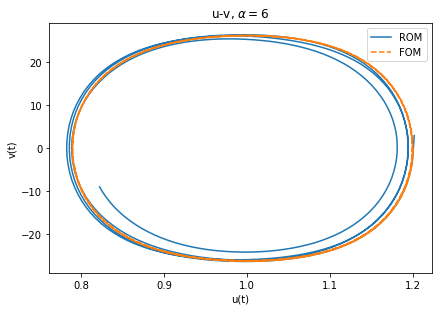

In [45]:
figure = plt.figure()
plt.plot(nln_predicted_disp[-1, :nln_t.shape[0]], nln_predicted_velocity[-1, :nln_t.shape[0]], label = 'ROM');
plt.plot(nln_moving_mesh[-1, :], nln_fl_velocity_end[-1, :], '--', label = 'FOM');
plt.tight_layout();
plt.legend();
plt.xlabel("u(t)")
plt.ylabel("v(t)")
plt.title(r"u-v, $\alpha = 6$");

**Energy indicators**

In [46]:
## Non linear model parameters
mu = mu_coeff * rigid / 0.2
A = 1
pres_init0 = 1e5
Ls0 = 1.2
L0 = 1

a = rigid;
b = mu;
c = A * pres_init0;
interm = (((np.sqrt((27 * b * c**2 + 4 * a**3) / b)) / (b * 2 * 3**(3. / 2.))) - c / (2 * b))**(1. / 3.);
u0 = interm - a / (3 * b * interm);
Lse = u0 + Ls0

# Mechanical energy definition (different formula for this nonlinear case)
def nln_mech_nrj(u_dot_t, u_t):
    return .5 * (mass * u_dot_t**2 + rigid * (-u_t - Ls0 + Lse)**2) + mu * .25 * (-u_t - Ls0 + Lse)**4  

nln_predicted_dt = np.concatenate((np.array([nln_t_data[0]]), np.diff(nln_prediction_t)))

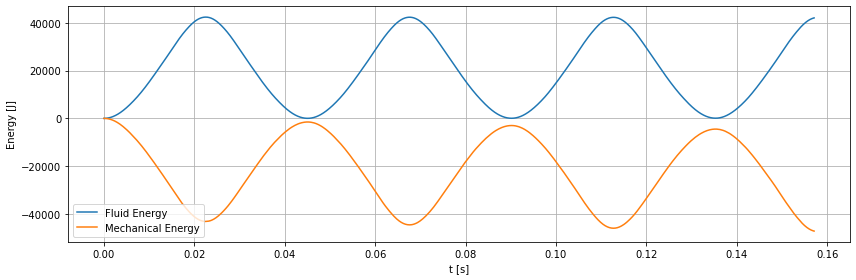

In [47]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_t_data, nln_Imp_fl, label = 'Fluid Energy');
plt.plot(nln_t_data, nln_Em - nln_Em[0], label = 'Mechanical Energy');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

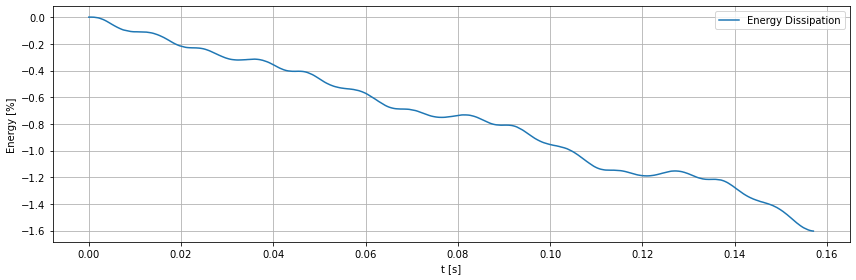

In [48]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_t_data, 100 * (nln_Imp_fl + nln_Em - nln_Em[0])/nln_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

In [49]:
nlndmd_imp_fl = fl_nrj(nln_predicted_pressure[-1, :], nln_predicted_dt, nln_predicted_velocity[-1, :])
nlndmd_Em = nln_mech_nrj(nln_predicted_velocity[-1, :], nln_predicted_disp[-1, :] - L0)

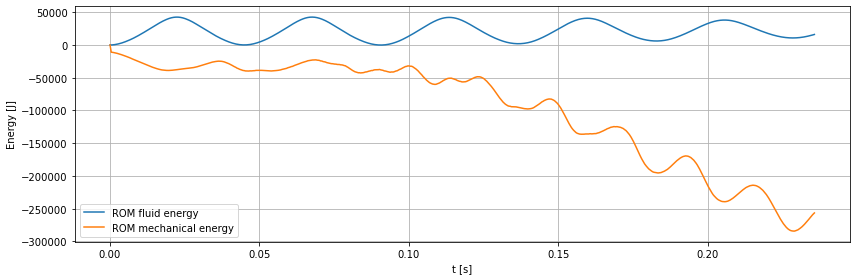

In [50]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_prediction_t, nlndmd_imp_fl, label = 'ROM fluid energy')
plt.plot(nln_prediction_t, nlndmd_Em - nlndmd_Em[0], label = 'ROM mechanical energy')
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [J]");
plt.legend();
plt.tight_layout();

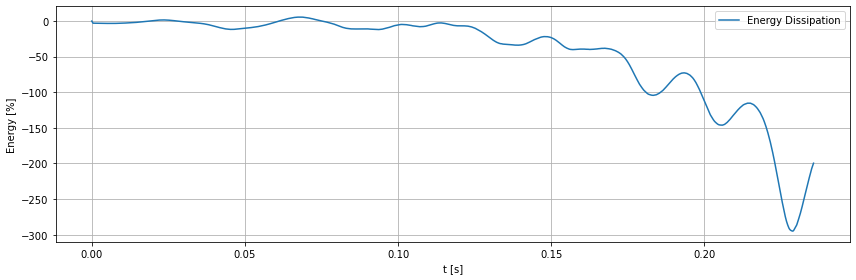

In [51]:
figure = plt.figure(figsize = (12, 4))
plt.plot(nln_prediction_t, 100 * (nlndmd_imp_fl + nlndmd_Em - nlndmd_Em[0])/nlndmd_Em, label = 'Energy Dissipation');
plt.grid();
plt.xlabel("t [s]");
plt.ylabel("Energy [%]");
plt.legend();
plt.tight_layout();

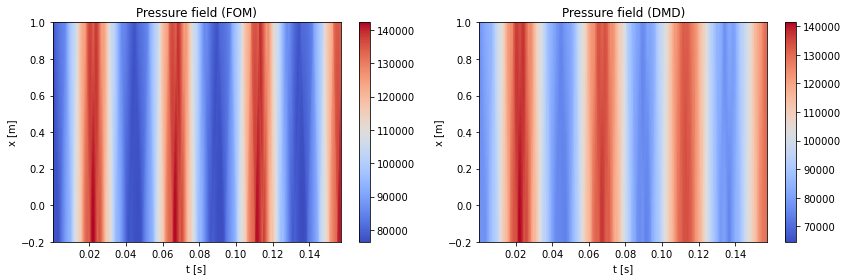

In [52]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

x0 = nln_t_data.copy()
y0 = nln_moving_mesh[:,0] - (nln_moving_mesh[:,0][-1] - L0)
z0 = nln_fl_pressure.copy()
z_min0, z_max0 = z0.min(), z0.max()

c0 = ax[0].pcolormesh(x0, y0, z0, cmap ='coolwarm', vmin = z_min0, vmax = z_max0)
plt.colorbar(c0, ax=ax[0])
ax[0].set_title('Pressure field (FOM)')
ax[0].set_ylabel("x [m]")
ax[0].set_xlabel("t [s]")


x1 = nln_prediction_t[:nln_t.shape[0]+1]
y1 = nln_moving_mesh[:,0] - (nln_mesh[:,0][-1] - L0)
z1 = nln_predicted_pressure[:, :nln_t.shape[0]+1].copy()
z_min1, z_max1 = z1.min(), z1.max()

c1 = ax[1].pcolormesh(x1, y1, z1, cmap ='coolwarm', vmin = z_min1, vmax = z_max1)
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Pressure field (DMD)')
ax[1].set_ylabel("x [m]")
ax[1].set_xlabel("t [s]")

plt.tight_layout()
plt.show()

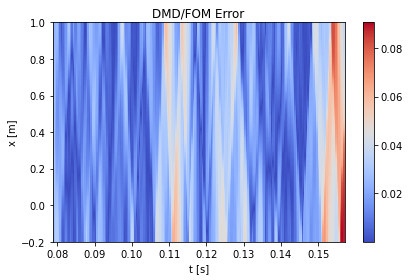

In [53]:
fig = plt.figure()

id0 = int(nln_ntt*Coeff)
id1 = nln_t.shape[0]
reference = test_nln_pressure
predicted = nln_predicted_pressure[:, id0:id1]

x0 = nln_t[id0::]
y0 = nln_moving_mesh[:,0] - (nln_moving_mesh[:,0][-1] - L0)
z0 = np.sqrt(((predicted - reference)**2))/np.sqrt(((reference)**2))
z_min0, z_max0 = z0.min(), z0.max()

c0 = plt.pcolormesh(x0, y0, z0, cmap ='coolwarm', vmin = z_min0, vmax = z_max0)
plt.colorbar(c0, ax=ax[0])
plt.title('DMD/FOM Error')
plt.ylabel("x [m]")
plt.xlabel("t [s]")
plt.colorbar()

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------